In [1]:
# Math 
from math import sqrt
from scipy import stats
import statistics
import os

# General
import numpy as np
import pandas as pd

# Sklearn Modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Graph
from tabulate import tabulate

# Custom Module's

from wrangle import wrangle_zillow_modeling, wrangle_zillow_exploration
import explore

#import evaluate
import warnings
warnings.filterwarnings("ignore")

# Exploration

In [2]:
train, validate, test = wrangle_zillow_exploration()

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13734 entries, 23415 to 7678
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   area       13734 non-null  float64
 1   bedrooms   13734 non-null  float64
 2   bathrooms  13734 non-null  float64
 3   tax_value  13734 non-null  float64
dtypes: float64(4)
memory usage: 536.5 KB


In [4]:
train.head()

area  bedrooms  bathrooms  tax_value
23415  1139.0       3.0        2.0   400834.0
27422  1666.0       3.0        2.0   530710.0
22548  1608.0       3.0        2.0   103502.0
21163  2565.0       4.0        3.0   394909.0
3347   2271.0       4.0        2.0  1009645.0

In [5]:
cols = list(train.columns)

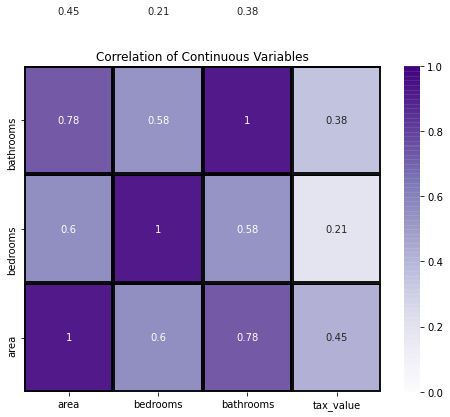

In [6]:
explore.create_heatmap(train, cols, descriptive=None)

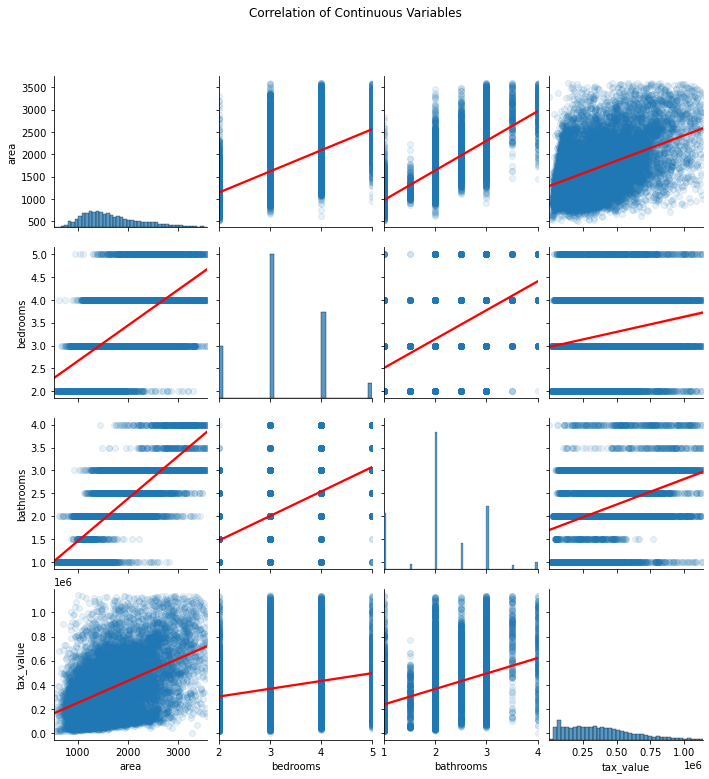

In [7]:
explore.plot_variable_pairs(train, cols, descriptive=None, hue=None)

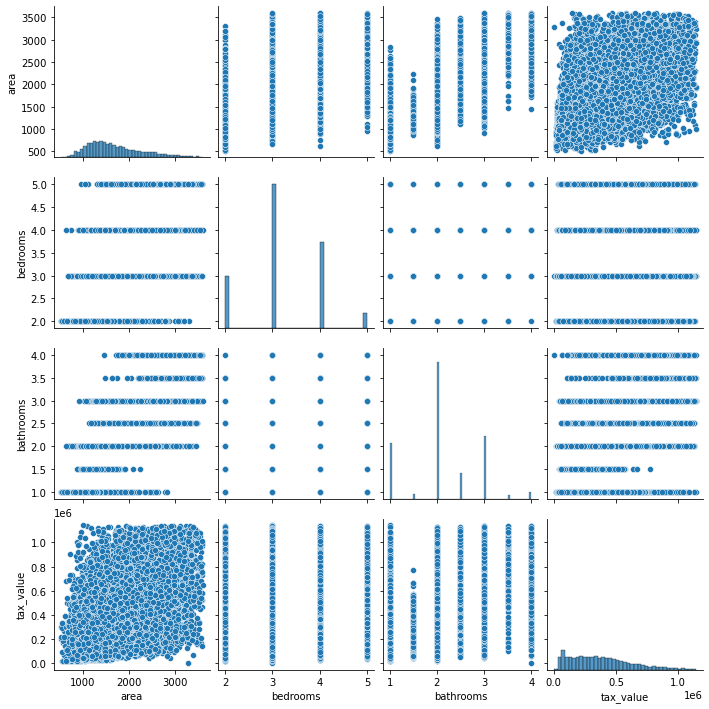

In [8]:
sns.pairplot(train)

    This showed me nothing, lets create some catagorical values

In [9]:
train['median_area'] = np.where(train.area > train.area.median(), 'larger', 'smaller')

In [10]:
train['median_bed'] = np.where(train.bedrooms > train.bedrooms.median(), 'larger', 'smaller')

In [11]:
train['median_bathrooms'] = np.where(train.bathrooms > train.bathrooms.median(), 'larger', 'smaller')

In [12]:
c_vars = 

In [21]:
categorical_vars = ['median_area', 'median_bed', 'median_bathrooms']
continuous_vars = ['tax_value']

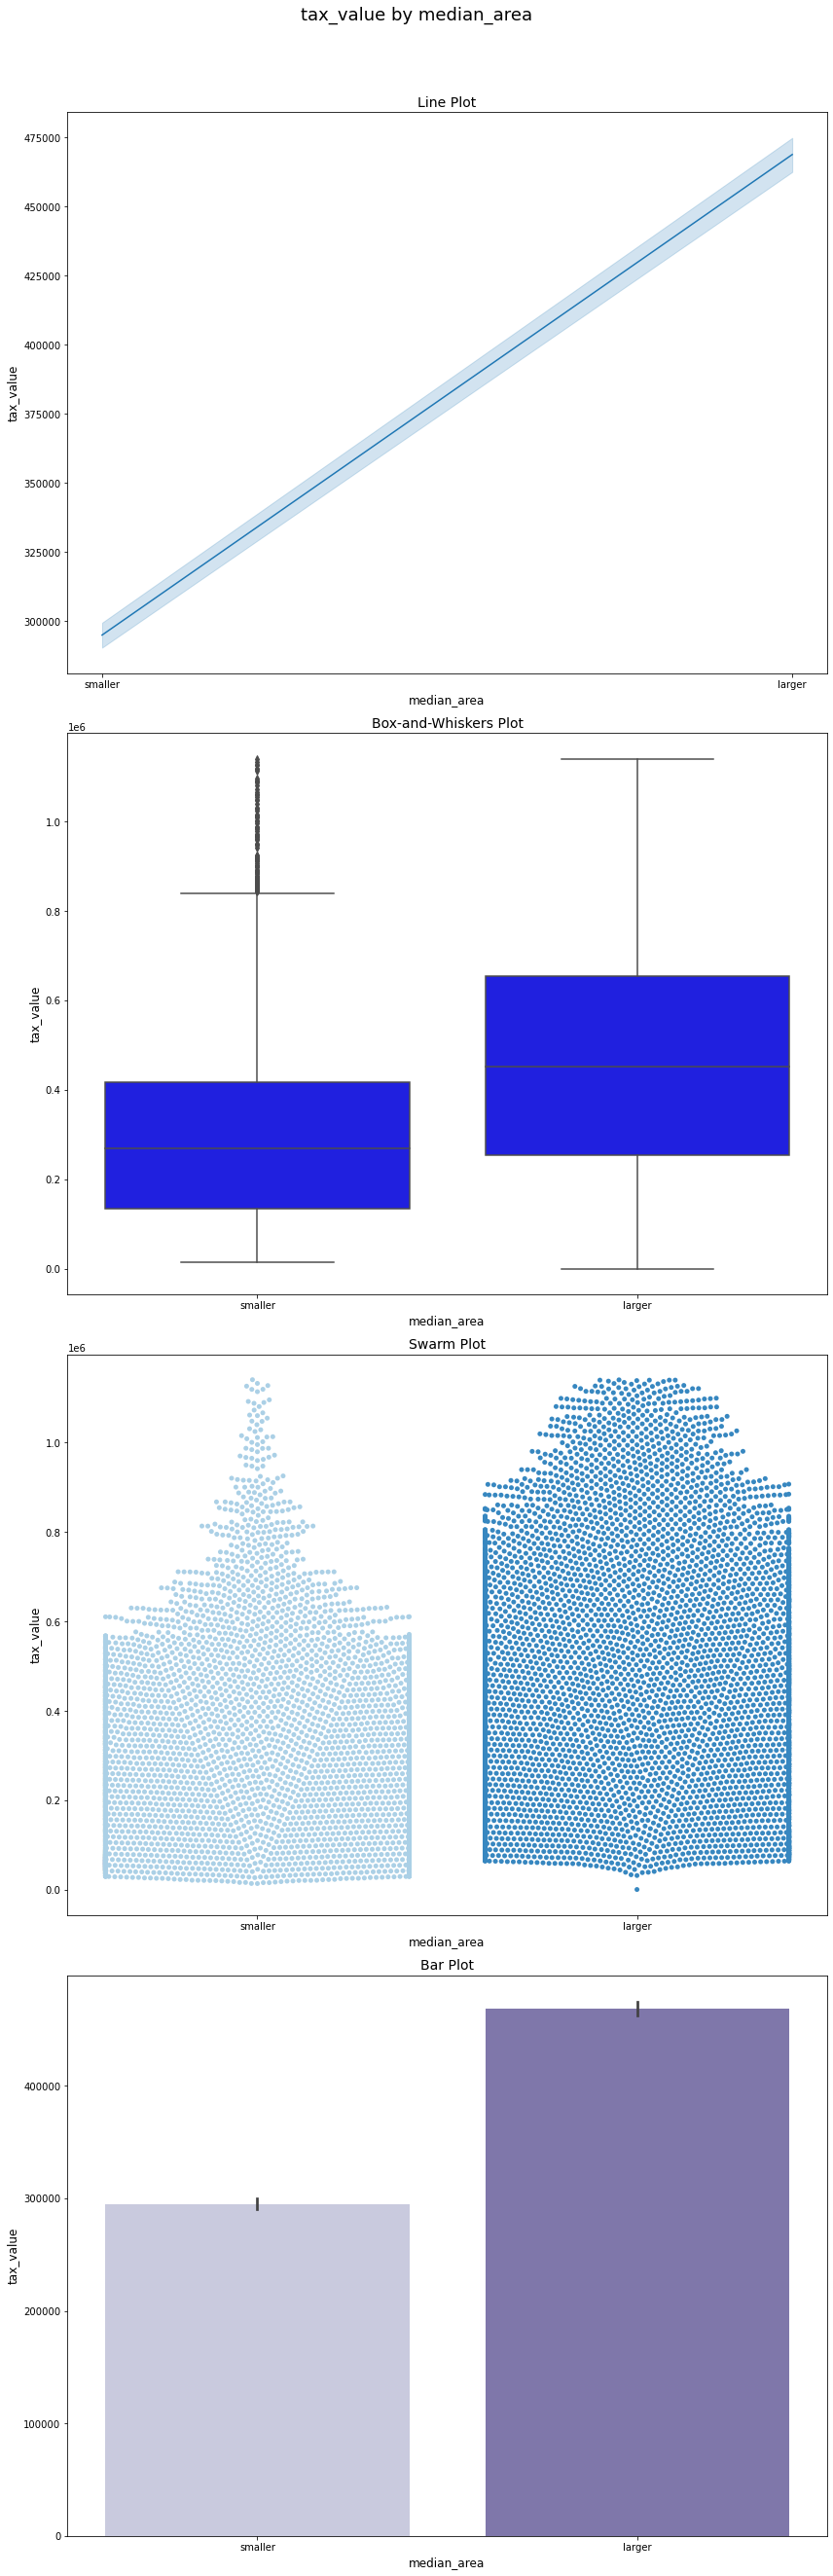

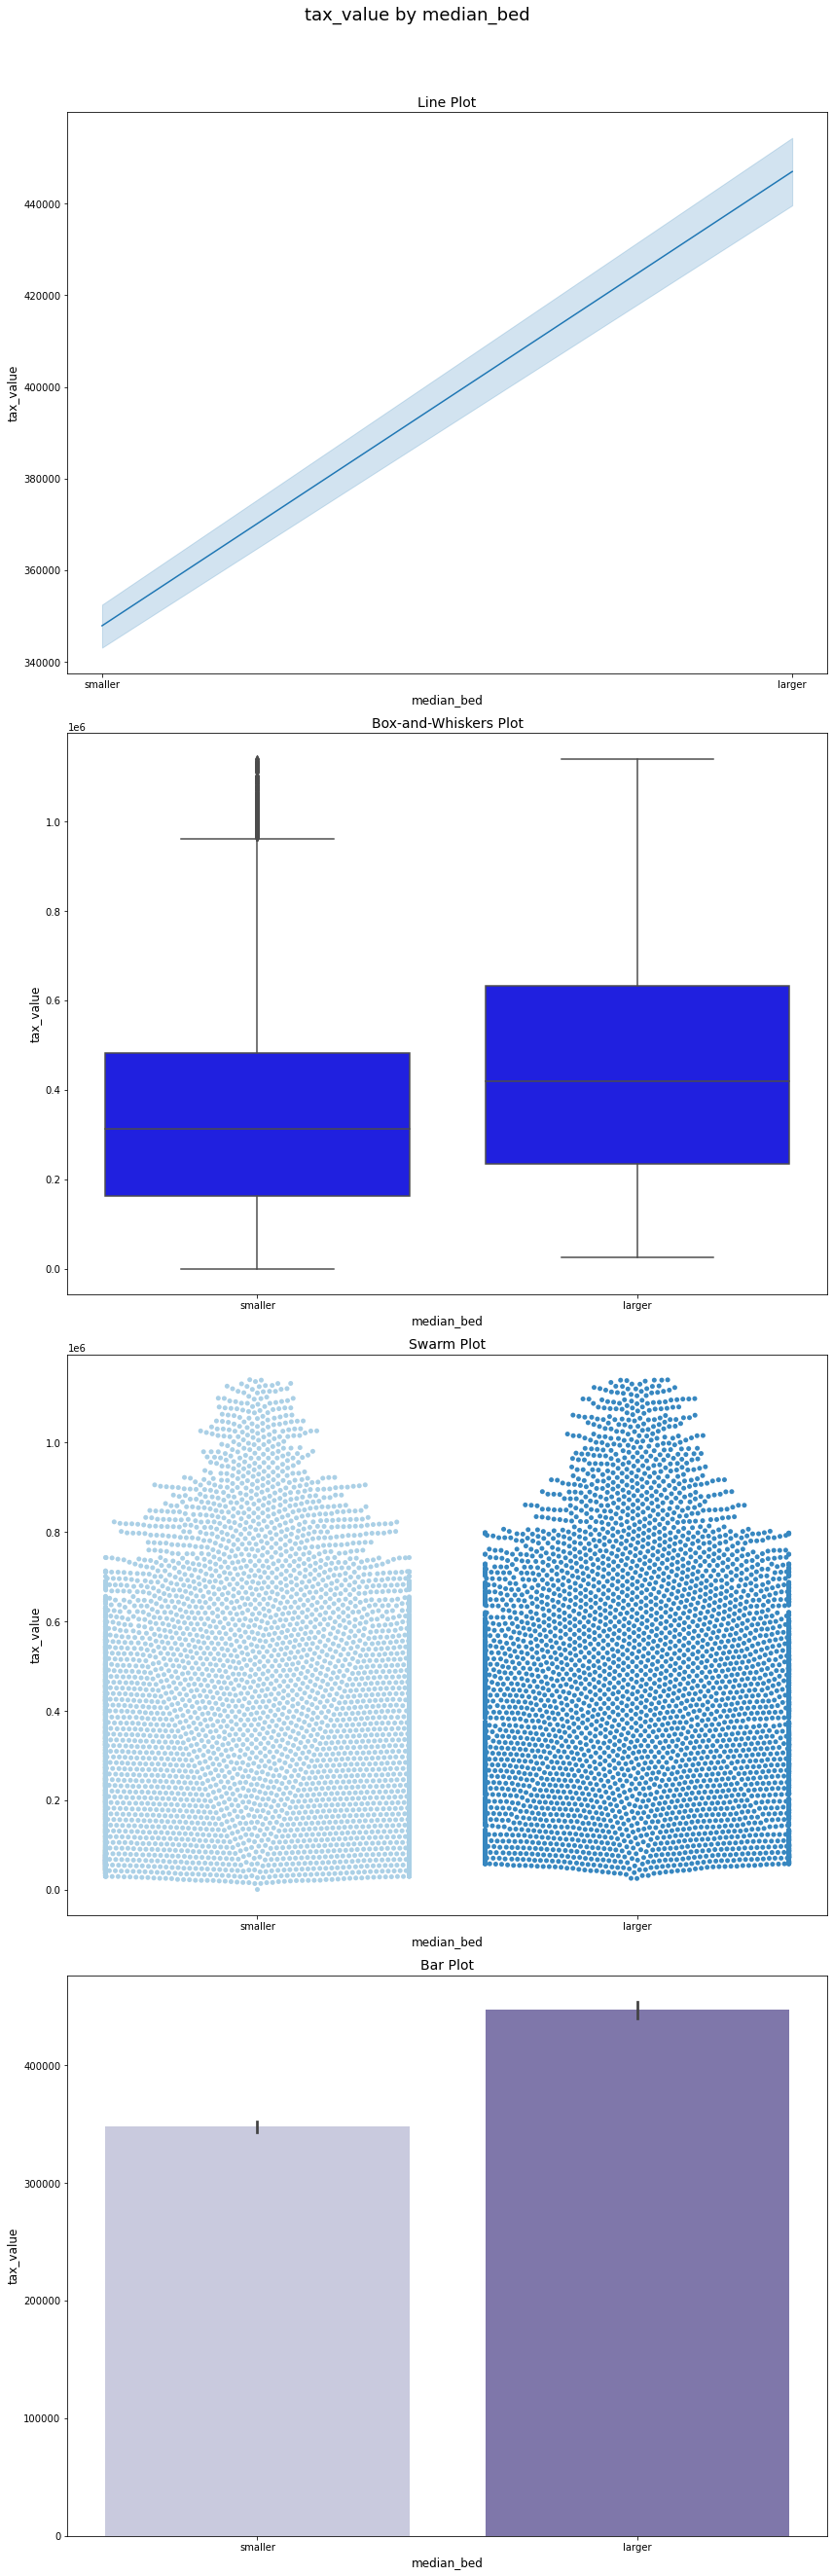

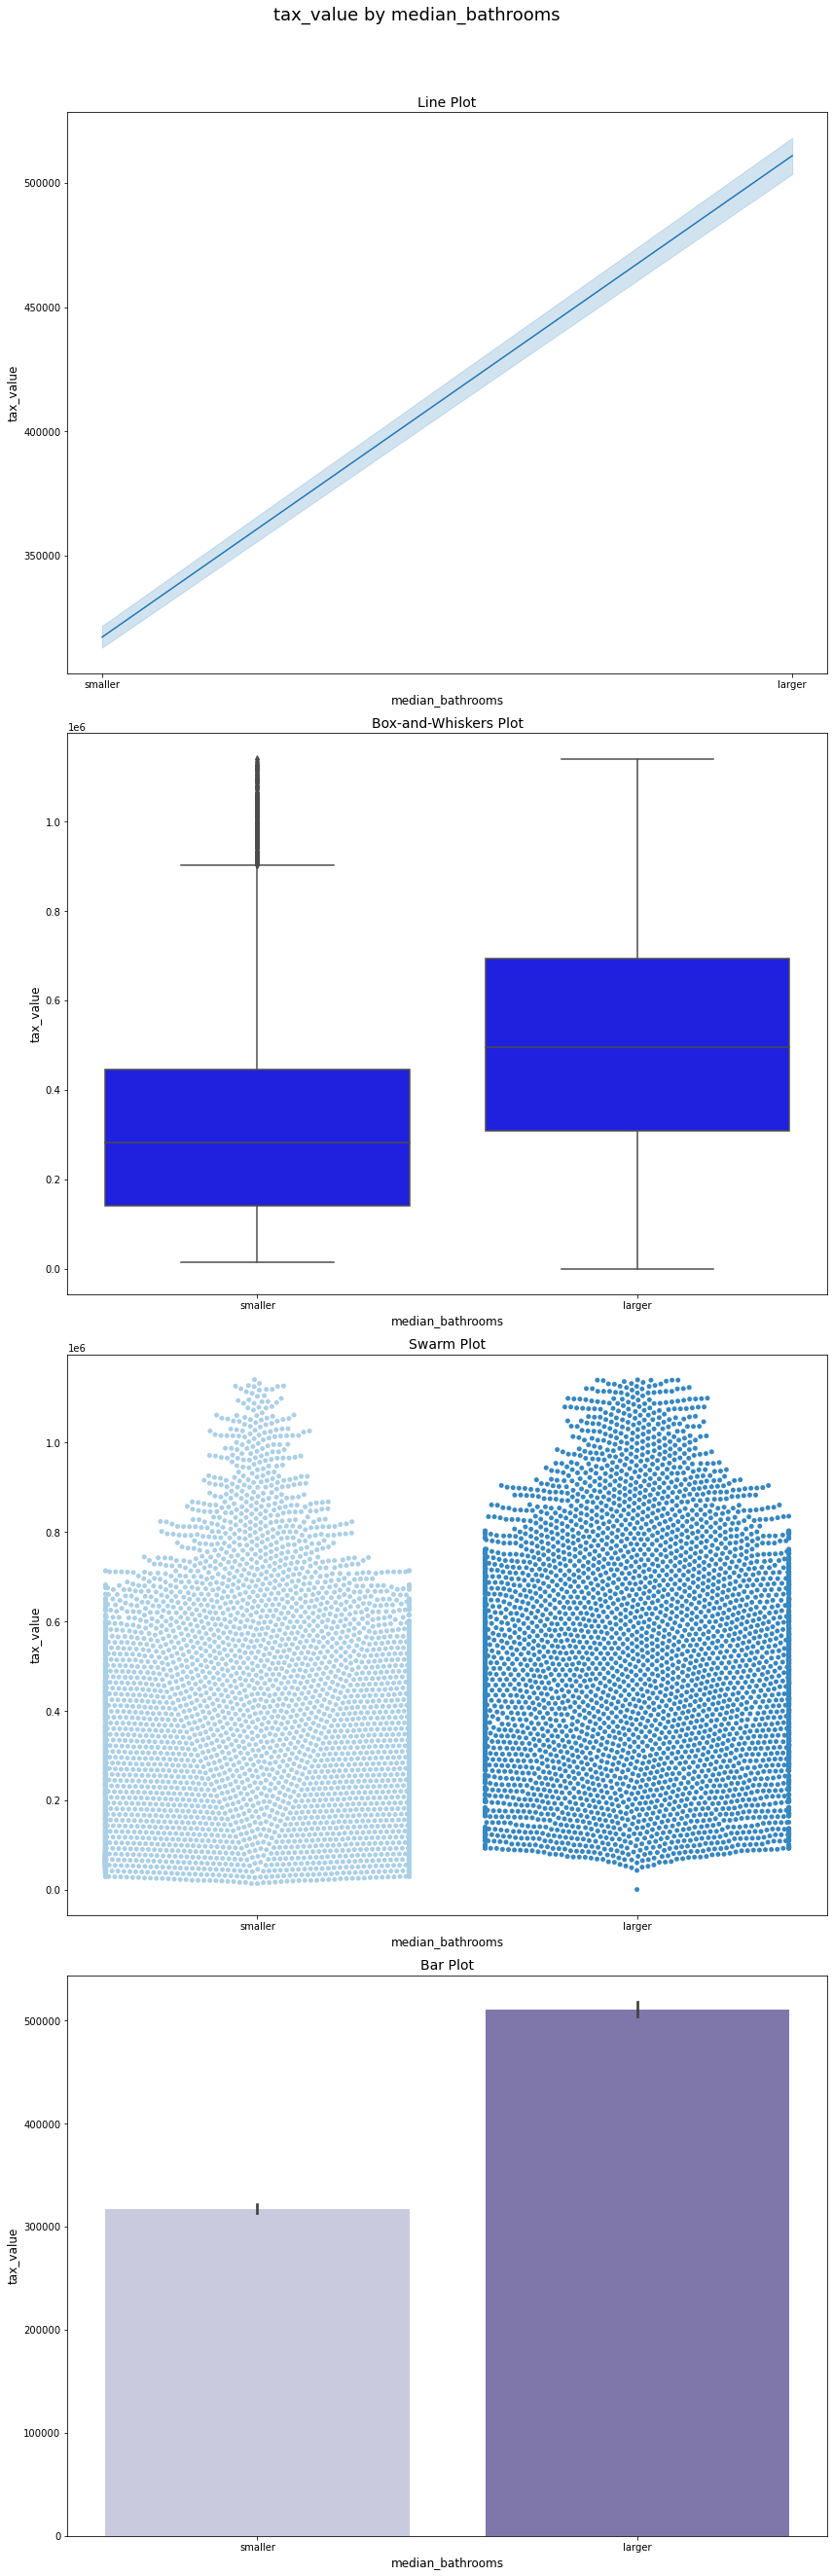

In [22]:
explore.plot_categorical_and_continuous_vars(categorical_vars, continuous_vars, train)

In [23]:
categorical_vars = ['median_area', 'median_bed', 'median_bathrooms']
continuous_vars = ['area']

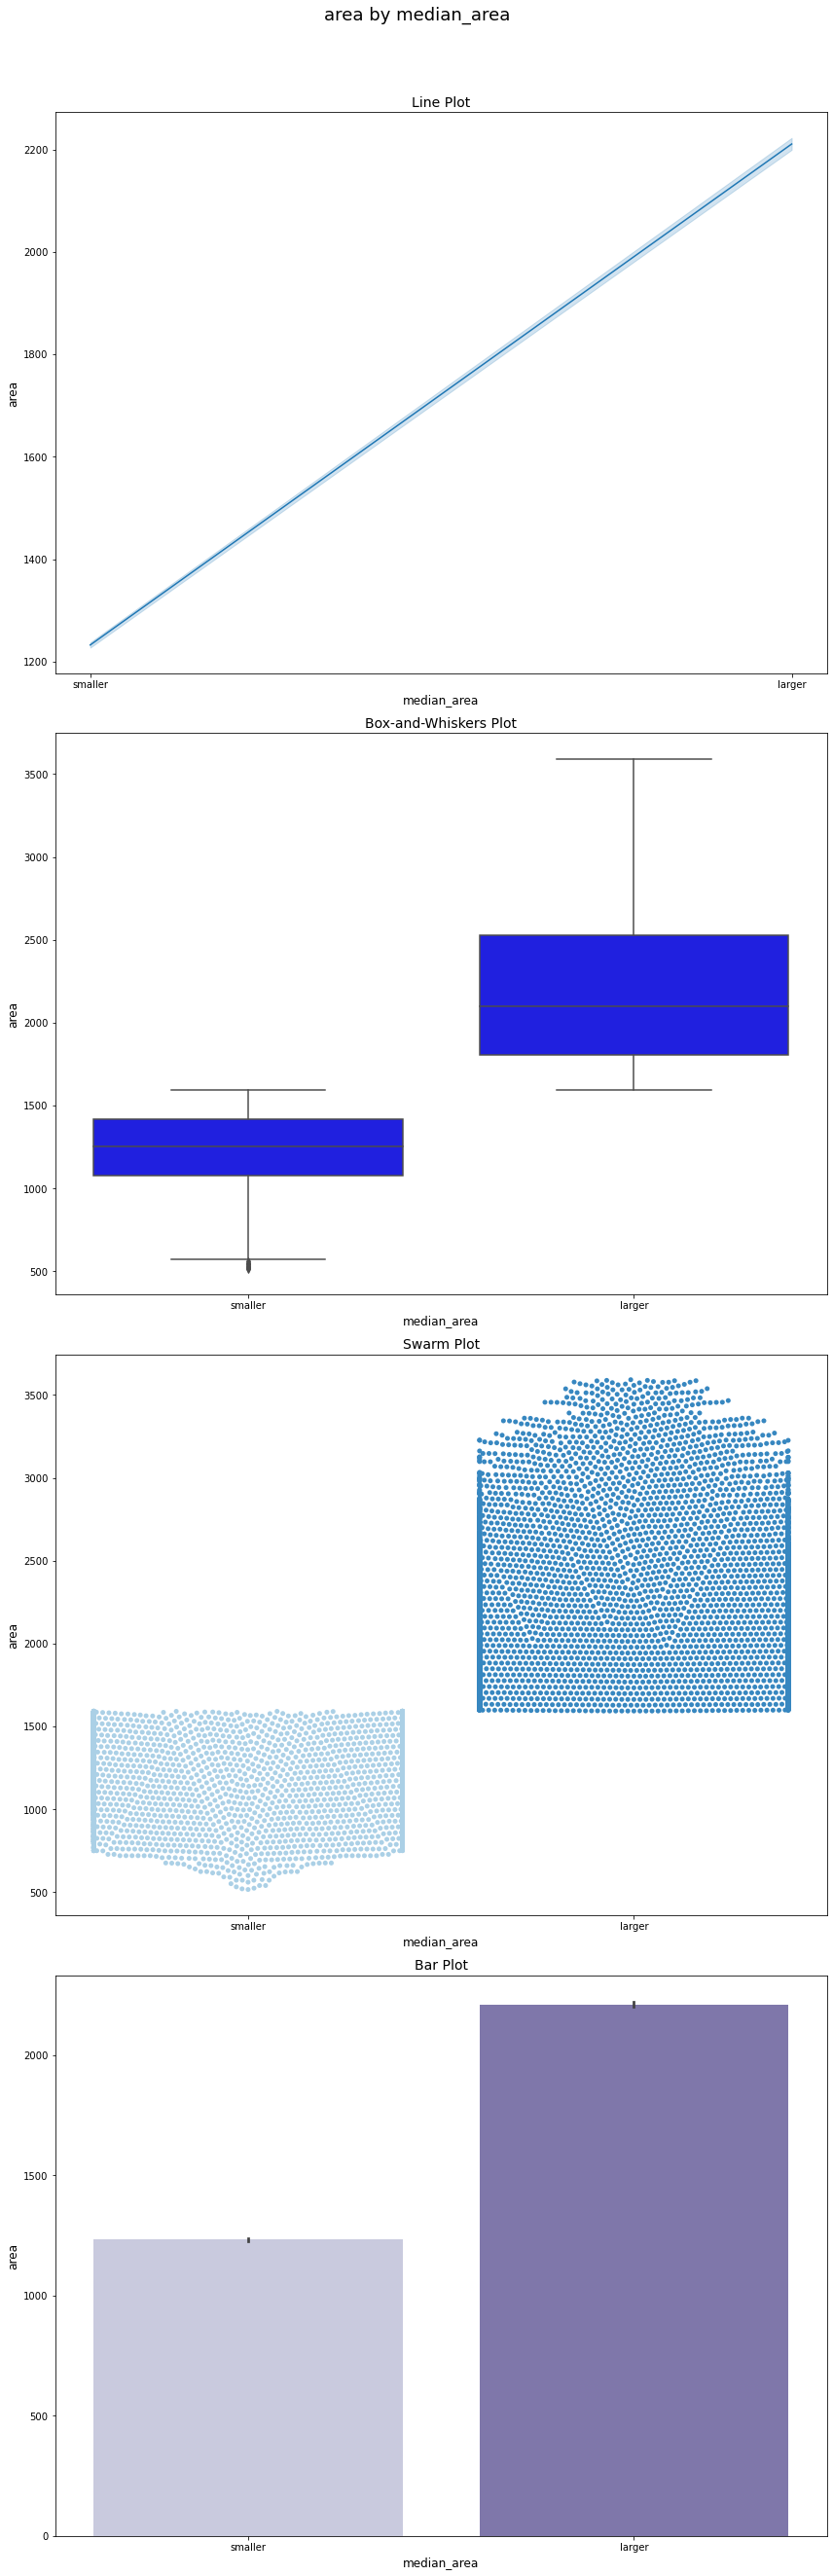

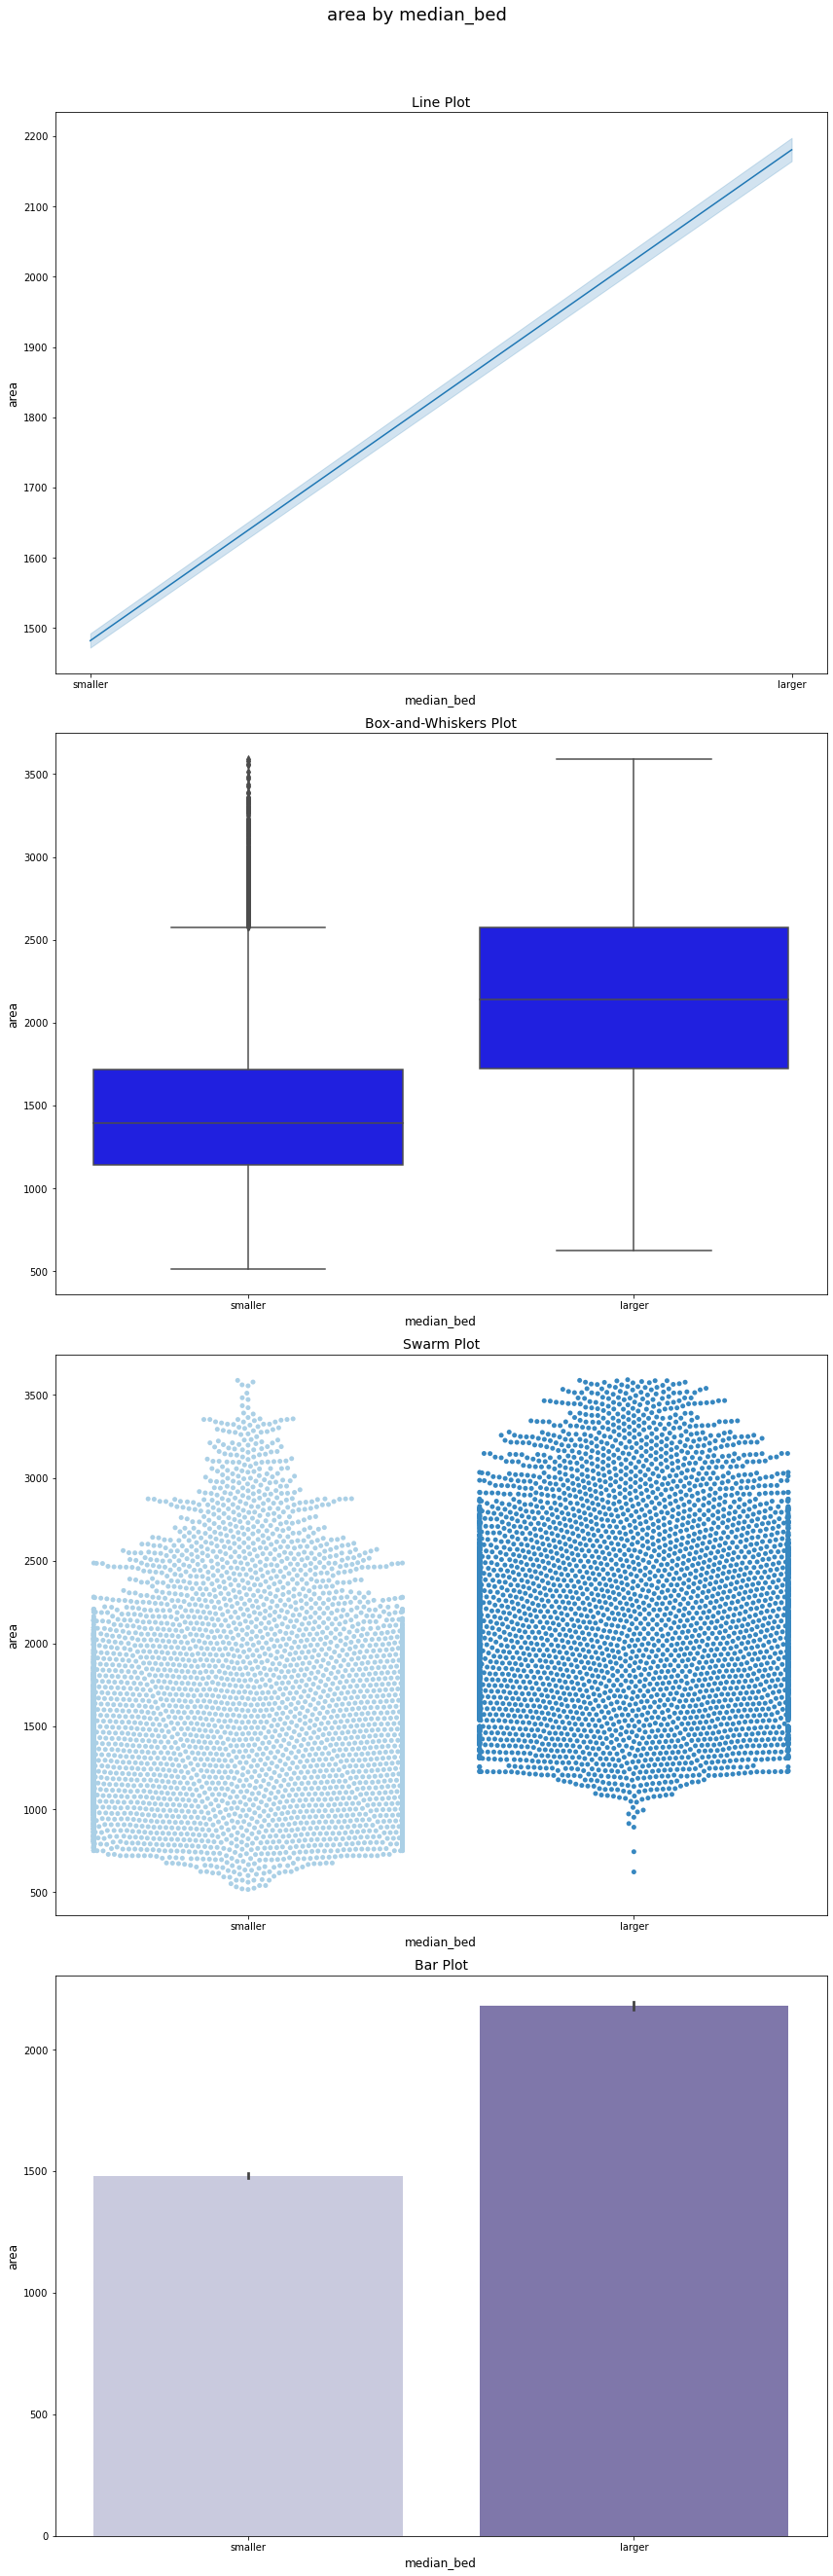

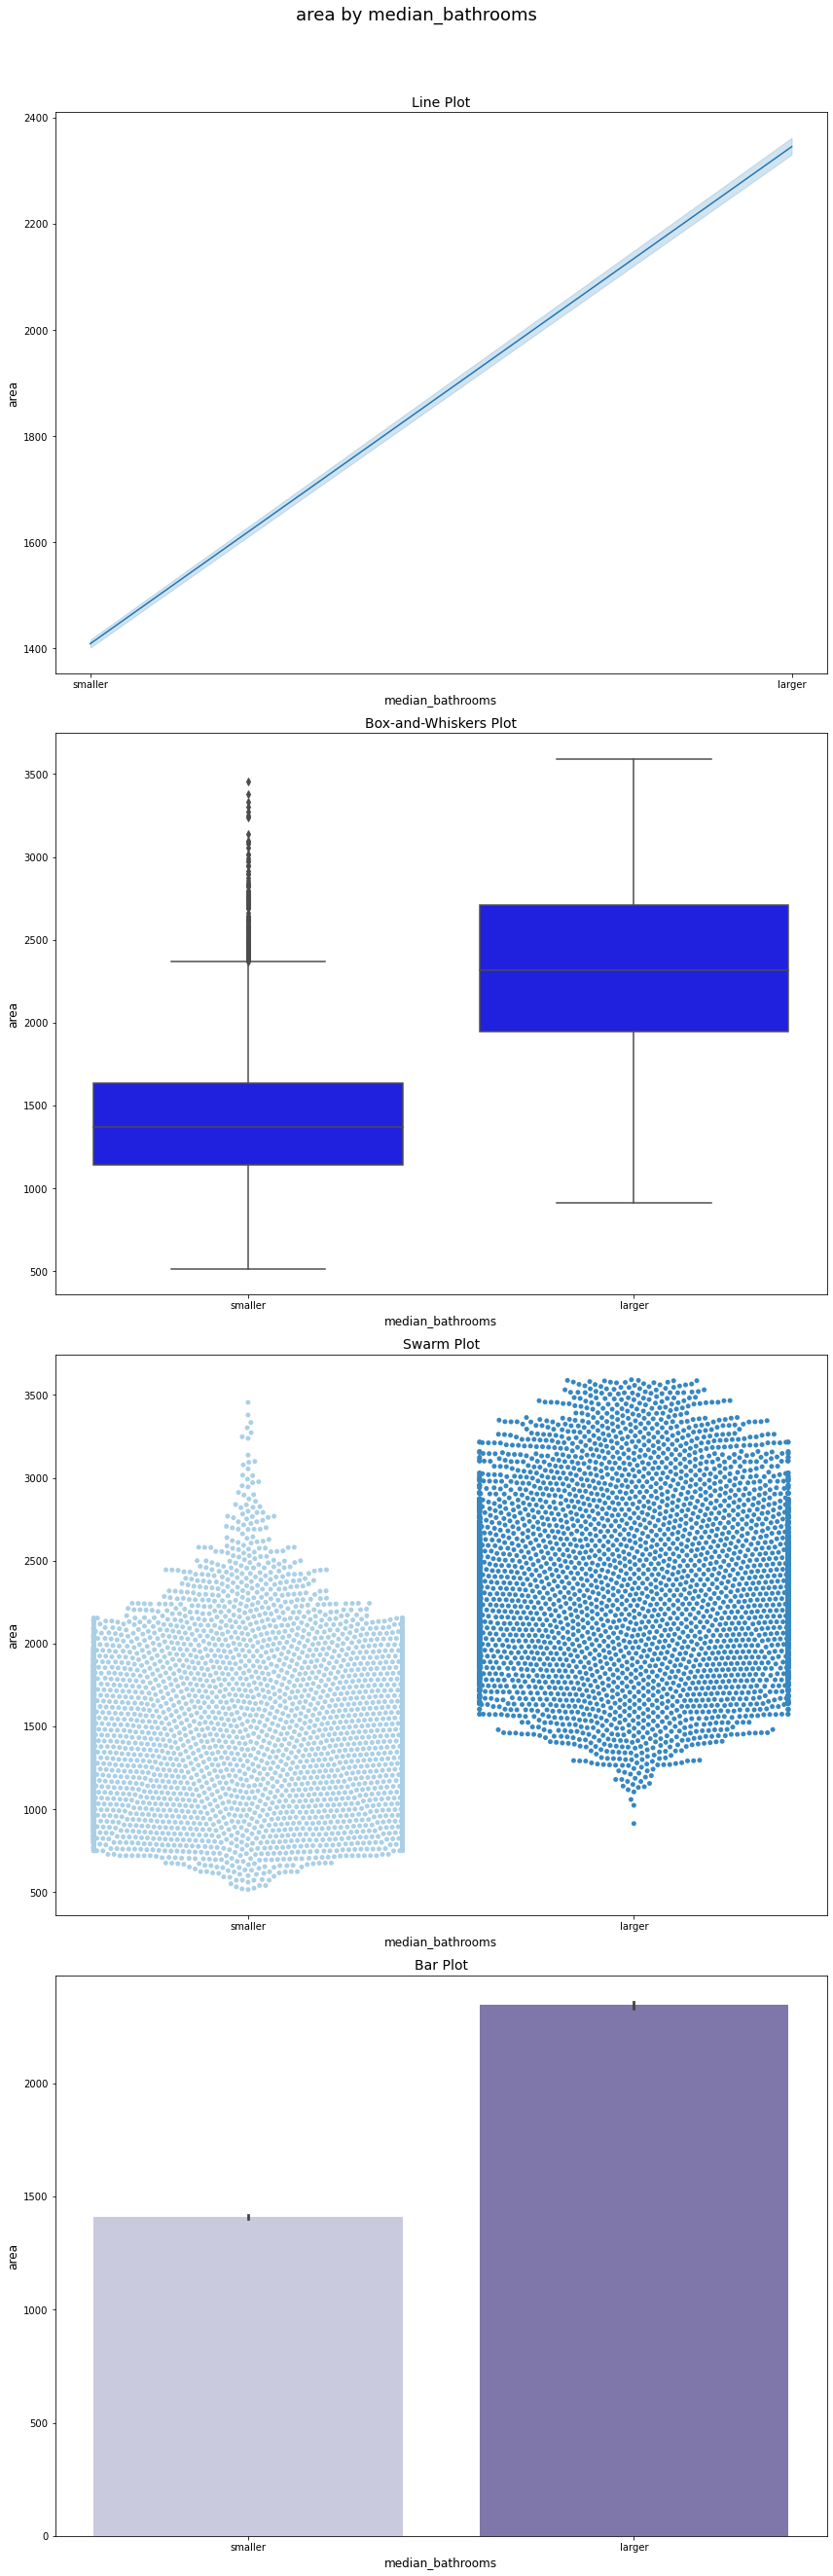

In [24]:
explore.plot_categorical_and_continuous_vars(categorical_vars, continuous_vars, train)

# Graph Takeaways

- Looks like heat map indicates area and bathrooms are more correlated 

- It looks like Area and bathrooms have more a role in increasing tax_value than bedrooms

- The larger the house, the larger the tax_value

- The more bathrooms, the larger the tax_value

- The more bedrooms, the larger the tax_value

- All features seem to be correlated, for example, the larger the area, the larger the house, the larger the bedrooms and bathrooms

- Using all features for modeling at once.

# Feature Engineering

In [29]:
train_s, validate_s, test_s = wrangle_zillow_modeling()

In [30]:
cols = list(train_s.columns)
cols

['area',
 'bedrooms',
 'bathrooms',
 'tax_value',
 'bedrooms_scaled',
 'bathrooms_scaled',
 'area_scaled']

In [32]:
X_train = train_s[['bedrooms_scaled', 'bathrooms_scaled', 'area_scaled']]
y_train = train_s['tax_value']

### Kbest

In [33]:
# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=1)

# find the top 8 X's correlated with y
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()
f_feature

['area_scaled']

In [41]:
# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=2)

# find the top 8 X's correlated with y
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()
f_feature

['bathrooms_scaled', 'area_scaled']

### RFE

In [34]:
# RFE time

# Make the thing(s)
lm = sklearn.linear_model.LinearRegression()
rfe = sklearn.feature_selection.RFE(lm, n_features_to_select=2)

# Fit the thing
rfe.fit(X_train, y_train)

# use the thing
rfe_columns = X_train.columns[rfe.support_].tolist()
rfe_columns

['bedrooms_scaled', 'area_scaled']

In [36]:
# RFE time

# Make the thing(s)
lm = sklearn.linear_model.LinearRegression()
rfe = sklearn.feature_selection.RFE(lm, n_features_to_select=1)

# Fit the thing
rfe.fit(X_train, y_train)

# use the thing
rfe_columns = X_train.columns[rfe.support_].tolist()
rfe_columns

['area_scaled']

In [37]:
def show_features_rankings(X_train, rfe):
    """
    Takes in a dataframe and a fit RFE object in order to output the rank of all features
    """
    # rfe here is reference rfe from cell 15
    var_ranks = rfe.ranking_
    var_names = X_train.columns.tolist()
    ranks = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
    ranks = ranks.sort_values(by="Rank", ascending=True)
    return ranks

In [38]:
def select_rfe(X, y, k):
    # make the thing
    lm = sklearn.linear_model.LinearRegression()
    rfe = sklearn.feature_selection.RFE(lm, n_features_to_select=k)

    # Fit the thing
    rfe.fit(X, y)
    
    # use the thing
    features_to_use = X.columns[rfe.support_].tolist()
    
    # we need to send show_feature_rankings a trained/fit RFE object
    all_rankings = show_features_rankings(X, rfe)
    
    return features_to_use, all_rankings

In [39]:
select_rfe(X_train, y_train, 1)

(['area_scaled'],
                 Var  Rank
 2       area_scaled     1
 0   bedrooms_scaled     2
 1  bathrooms_scaled     3)

In [40]:
select_rfe(X_train, y_train, 2)

(['bedrooms_scaled', 'area_scaled'],
                 Var  Rank
 0   bedrooms_scaled     1
 2       area_scaled     1
 1  bathrooms_scaled     2)

# Feature Engineering takeaways

- Kbest k=1 suggests area_scaled is best feature

- Kbest k=2 suggests area_scaled and bathroom_scaled are the top two

- RFE n=1 suggests area_scaled is best feature

- RFE n=2 suggests area_scaled and bedroom_scaled are the top two

# Exploration Take Away

- Going to run all features into model

- Going to run just area_scaled into model

- Going to run area_scaled and bathrooms_scaled

- Going to run area_scaled and bedrooms_scaled